In [ ]:
#| hide
from diffusion_curvature.datasets import *
from diffusion_curvature.kernels import *
from nbdev import show_doc
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Diffusion Curvature

> Fast, pointwise graph curvature

>[!INFO] This code is currently in *early beta*. Some features, particularly those relating to dimension estimation and the construction of comparison spaces, are experimental and will likely change. Please report any issues you encounter to the Github Issues page.

Diffusion curvature is a pointwise extension of Ollivier-Ricci curvature, designed specifically for the often messy world of pointcloud data.
Its advantages include:

1. Unaffected by density fluctuations in data: it inherits the diffusion operator's denoising properties.
2. Fast, and scalable to millions of points: it depends only on matrix powering - no optimal transport required.

## Install

<!-- To install with conda (or better yet, mamba),
```sh
conda install diffusion-curvature -c riddlelabs
``` -->

To install with pip (or better yet, poetry), 

```sh
pip install diffusion-curvature
```

or
```sh
poetry add diffusion-curvature
```

Conda releases are pending.

## Usage

To compute diffusion curvature, first create a `graphtools` graph with your data. Graphtools offers extensive support for different kernel types (if creating from a pointcloud), and can also work with graphs in the `PyGSP` format. We recommend using `anistropy=1`, and verifying that the supplied knn value encompasses a reasonable portion of the graph.

In [ ]:
from diffusion_curvature.datasets import torus
import graphtools
X_torus, torus_gaussian_curvature = torus(n=5000)
G_torus = graphtools.Graph(X_torus, anisotropy=1, knn=30)

Graphtools offers many additional options. For large graphs, you can speed up the powering of the diffusion matrix with landmarking: simply pass `n_landmarks=1000` (e.g) when creating the graphtools graph. If you enable landmarking, `diffusion-curvature` will automatically use it.

Next, instantiate a `DiffusionCurvature` operator. 

In [ ]:
from diffusion_curvature.graphtools import DiffusionCurvature
DC = DiffusionCurvature(t=12)

In [ ]:
show_doc(DiffusionCurvature)

---

[source](https://github.com/professorwug/diffusion_curvature/blob/main/diffusion_curvature/graphtools.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### DiffusionCurvature

>      DiffusionCurvature (t:int, distance_type='PHATE', dimest=None,
>                          use_entropy:bool=False, **kwargs)

Initialize self.  See help(type(self)) for accurate signature.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| t | int |  | Number of diffusion steps to use when measuring curvature. TODO: Heuristics |
| distance_type | str | PHATE |  |
| dimest | NoneType | None | Dimensionality estimator to use. If None, defaults to KNN with default params |
| use_entropy | bool | False | If true, uses KL Divergence instead of Wasserstein Distances. Faster, seems empirically as good, but less proven. |
| kwargs |  |  |  |

And, finally, pass your graph through it. The `DiffusionCurvature` operator will store everything it computes -- the powered diffusion matrix, the estimated manifold distances, and the curvatures -- as attributes of your graph.
To get the curvatures, you can run `G.ks`.


In [ ]:
G_torus = DC.curvature(G_torus, dimension=2) # note: this is the intrinsic dimension of the data

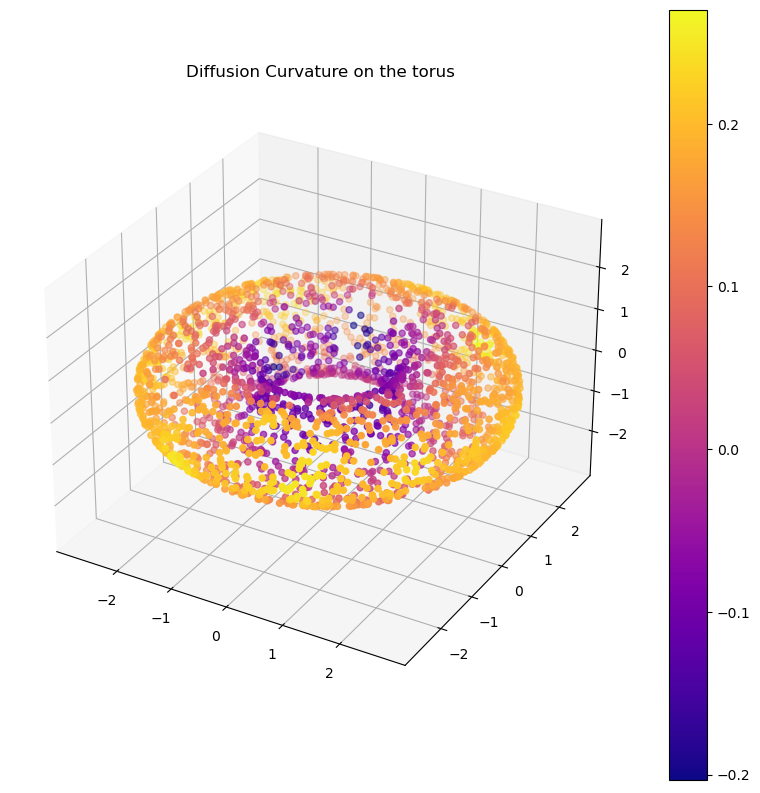

In [ ]:
plot_3d(X_torus, G_torus.ks, colorbar=True, title="Diffusion Curvature on the torus")

# Using on a predefined graph

If you have an adjacency matrix but no pointcloud, diffusion curvature may still be useful. The caveat, currently, is that our intrinsic dimension estimation doesn't yet support graphs, so you'll have to compute & provide the dimension yourself -- if you want a signed curvature value.

If you're only comparing relative magnitudes of curvature, you can skip this step.

For predefined graphs, we use our own `ManifoldGraph` class. You can create one straight from an adjacency matrix:

In [ ]:
from diffusion_curvature.manifold_graph import ManifoldGraph, diffusion_curvature, diffusion_entropy_curvature, entropy_of_diffusion, wasserstein_spread_of_diffusion, power_diffusion_matrix, phate_distances, flattened_facsimile_of_graph

In [ ]:
# pretend we've computed the adjacency matrix elsewhere in the code
A = G_torus.K.toarray()
# initialize the manifold graph; input your computed dimension along with the adjacency matrix
G_pure = ManifoldGraph(A, dimension=2)

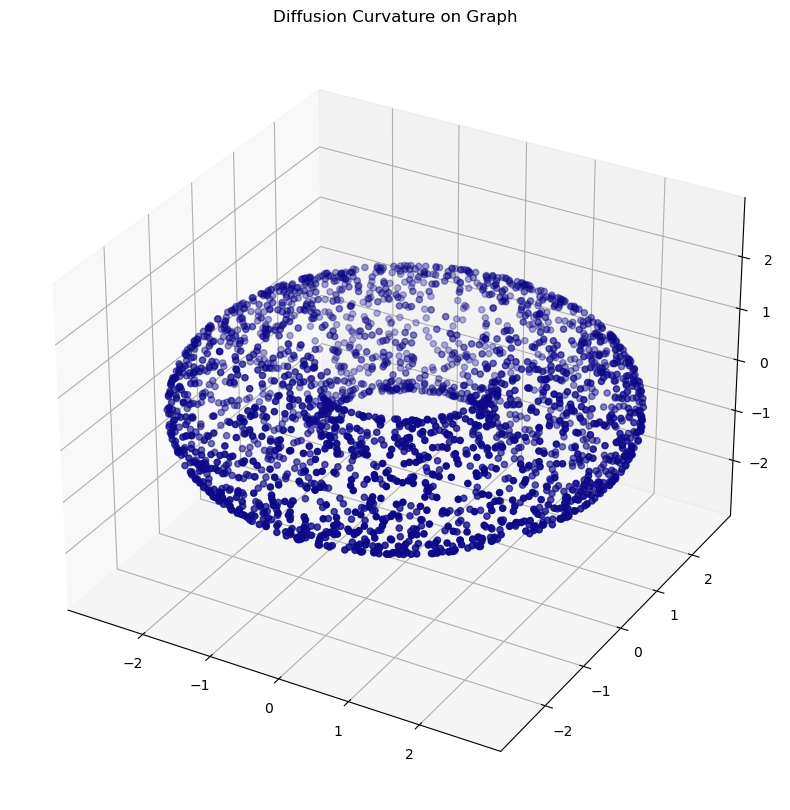

In [ ]:
G_pure = diffusion_curvature(G_pure, t=12)
plot_3d(X_torus, G_pure.ks, title = "Diffusion Curvature on Graph")

Alternately, to compute just the *relative magnitudes* of the pointwise curvatures (without signs), we can directly use either the `wasserstein_spread_of_diffusion` (which computes the $W_1$ distance from a dirac to its t-step diffusion), or the `entropy_of_diffusion` function (which computes the entropy of each t-step diffusion). The latter is nice when the manifold's geodesic distances are hard to estimate -- it corresponds to replacing the wasserstein distance with the KL divergence.

In [ ]:
# for the wasserstein version, we need manifold distances
G_pure = power_diffusion_matrix(G_pure)
G_pure = phate_distances(G_pure)
ks_wasserstein = wasserstein_spread_of_diffusion(G_pure)


In [ ]:
# for the entropic version, we need only power the diffusion operator
G_pure = power_diffusion_matrix(G_pure, t=12)
ks_entropy = entropy_of_diffusion(G_pure)